## RQ1: How relevant is GitHub Actions compared to other CI/CD tools?

## 1. Data collection and processing

Data was collected using SEDE (Stack Exchange Data Explorer), focusing on the six most relevant CI/CD tools. The data spans from 2019 to August 3, 2024.

In [38]:
import pandas as pd

# Load the three datasets
df_2019_2020 = pd.read_csv(f'..\RQ1_Relevance\data\\raw_data\cicd_tools_stackoverflow_2019_2021.csv')
df_2021_2022 = pd.read_csv(f'..\RQ1_Relevance\data\\raw_data\cicd_tools_stackoverflow_2021_2023.csv')
df_2023_2024 = pd.read_csv(f'..\RQ1_Relevance\data\\raw_data\cicd_tools_stackoverflow_2023_.csv')

# Combine the datasets into a single DataFrame
df = pd.concat([df_2019_2020, df_2021_2022, df_2023_2024])

# Convert CreationDate to datetime
df['CreationDate'] = pd.to_datetime(df['CreationDate'])

# List of CI/CD tools
cicd_tools = ['github-actions', 'jenkins', 'gitlab-ci', 'azure-devops', 'travis-ci', 'circleci']

In [39]:
# Count the number of posts by each TagName
tagname_counts = df['TagName'].value_counts()
print('Number of posts by tool:', tagname_counts)

# Calculate the total number of posts
total_posts = df.shape[0]
print('Total number of posts:', total_posts)

Number of posts by tool: TagName
azure-devops      24620
jenkins           19850
github-actions    10862
gitlab-ci          7020
circleci           1086
travis-ci           940
Name: count, dtype: int64
Total number of posts: 64378


In [43]:
df.to_csv(f'..\RQ1_Relevance\data\processed_data\cicd_tools.csv')

Answers were collected also SEDE, and correspond to the answers of the posts collected previously

In [44]:
# Load the three datasets of answers
df_answers_2019_2021 = pd.read_csv(f'..\RQ1_Relevance\data\\raw_data\\answers_2019_to_2021.csv')
df_answers_2021_2022 = pd.read_csv(f'..\RQ1_Relevance\data\\raw_data\\answers_2021_to_2022.csv')
df_answers_2022_ = pd.read_csv(f'..\RQ1_Relevance\data\\raw_data\\answers_2022_to_.csv')

# Combine the datasets into a single DataFrame
df_answers = pd.concat([df_answers_2019_2021, df_answers_2021_2022, df_answers_2022_])

In [46]:
df.to_csv(f'..\RQ1_Relevance\data\processed_data\cicd_tools_answers.csv')

## 2. Data analysis

### 2.1.- Popularity over time

Plotting the monthly number of posts for each post from the beginning of 2019 to July 2024

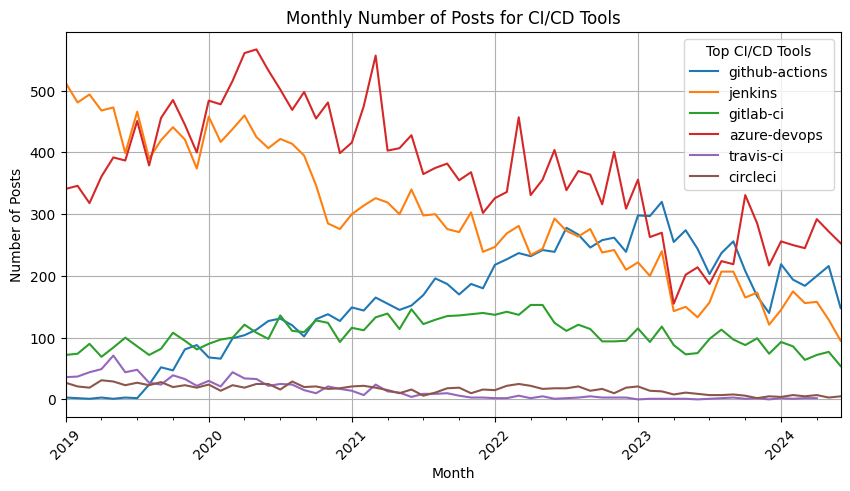

In [50]:
import matplotlib.pyplot as plt

# Initialize a dictionary to store the results
results_score = {}
monthly_posts_data = {}

for tool in cicd_tools:
    
    # Filter data for the current tool
    tool_df = df[df['TagName'] == tool]
    
    # Separate questions and answers
    questions = tool_df[tool_df['PostTypeId'] == 1].copy()
    answers = tool_df[tool_df['PostTypeId'] == 2].copy()

    # Calculate Metrics
    avg_view = questions['ViewCount'].mean()
    avg_fav = questions['FavoriteCount'].mean()
    avg_score = questions['Score'].mean()
    avg_ans = questions['AnswerCount'].mean()
    avg_answer_score = answers['Score'].mean() if not answers.empty else float('nan')
    total_answers = questions['AnswerCount'].sum()
    total_questions = questions.shape[0]
    answers_per_question = total_answers / total_questions if total_questions > 0 else float('nan')
    unanswered_questions = questions[questions['AnswerCount'] == 0].shape[0]
    unanswered_question_ratio = unanswered_questions / total_questions if total_questions > 0 else float('nan')
    
    # Response Time Calculation
    merged_df = pd.merge(answers, questions[['PostId', 'CreationDate']], left_on='ParentId', right_on='PostId', suffixes=('_answer', '_question'))
    merged_df['responseTime'] = (merged_df['CreationDate_answer'] - merged_df['CreationDate_question']).dt.total_seconds() / 3600
    avg_response_time = merged_df['responseTime'].mean()
    
    # Store results in the dictionary
    results_score[tool] = {
        'avg_view': avg_view,
        'avg_fav': avg_fav,
        'avg_score': avg_score,
        'avg_ans': avg_ans,
        'avg_answer_score': avg_answer_score,
        'answers_per_question': answers_per_question,
        'unanswered_question_ratio': unanswered_question_ratio,
        'avg_response_time': avg_response_time,
        'total_questions': total_questions
    }

    # Calculate monthly number of posts
    monthly_posts = tool_df.resample('M', on='CreationDate').size()
    monthly_posts_data[tool] = monthly_posts

# Step 1: Find the last complete month
last_complete_month = df['CreationDate'].max().replace(day=1) - pd.offsets.MonthBegin(1)

# Step 2: Filter the monthly_posts_data to include only data up to the last complete month
filtered_monthly_posts_data = {tool: data[data.index <= last_complete_month] for tool, data in monthly_posts_data.items()}

# Step 3: Plot the filtered data
plt.figure(figsize=(10, 5))
for tool in cicd_tools:
    filtered_monthly_posts_data[tool].plot(label=tool)

plt.title('Monthly Number of Posts for CI/CD Tools')
plt.xlabel('Month')
plt.ylabel('Number of Posts')
plt.legend(title="Top CI/CD Tools")
plt.xticks(rotation=45)
plt.grid(True)

# Save the plot to a file named 'figs.png'
plt.savefig('figs/ci_tools_until_Jul_2024.png')

plt.show()

In [9]:
# Extract the year from the CreationDate
df['Year'] = df['CreationDate'].dt.year

# Filter only questions (PostTypeId == 1)
questions_df = df[df['PostTypeId'] == 1]

# Group by Year and TagName, then count the number of questions
yearly_question_count = questions_df.groupby(['Year', 'TagName']).size().unstack(fill_value=0)

# Display the table
print(yearly_question_count)

TagName  azure-devops  circleci  github-actions  gitlab-ci  jenkins  travis-ci
Year                                                                          
2019             4761       290             307       1013     5340        474
2020             5943       251            1325       1315     4744        296
2021             4833       183            1999       1560     3586        113
2022             4309       218            2945       1475     3071         37
2023             2923       111            2899       1131     2118         13
2024             1851        33            1387        526      991          7


## 2.- Percentage of Non Answered questions (%nAA) and Average Response Time (RT) over time

To obatain the RT of a questions, we calculate the amount of time between when the question is made and when the accepted answer is posted.

In [13]:
# Assuming 'df' is your DataFrame

# Step 1: Extract the year from the 'CreationDate' column
df['Year'] = pd.to_datetime(df['CreationDate']).dt.year

# Step 2: Group by 'TagName' and 'Year'
grouped = df.groupby(['TagName', 'Year'])

# Step 3: Calculate %nAA for each tool and year
results_score = []

for (tag, year), group in grouped:
    # Total number of questions
    total_questions = len(group)
    
    # Number of questions without an accepted answer
    no_accepted_answer = group['AcceptedAnswerId'].isna().sum()
    
    # Calculate %nAA
    percent_nAA = (no_accepted_answer / total_questions) * 100 if total_questions > 0 else 0
    
    # Store the results
    results_score.append({
        'Year': year,
        'Tool': tag,
        'Total Questions': total_questions,
        '%nAA': round(percent_nAA, 2)
    })

# Convert the results to a DataFrame
results_nAA_df = pd.DataFrame(results_score).sort_values(by=['Year','Tool'])

# Display the results
results_nAA_df.reset_index(drop=True)

,Year,Tool,Total Questions,%nAA
0,2019,azure-devops,4761,46.99
1,2019,circleci,290,54.83
2,2019,github-actions,307,34.53
3,2019,gitlab-ci,1013,57.95
4,2019,jenkins,5340,67.25
5,2019,travis-ci,474,58.86
6,2020,azure-devops,5943,39.93
7,2020,circleci,251,58.96
8,2020,github-actions,1325,49.96
9,2020,gitlab-ci,1315,60.68


In [14]:
# Assuming 'df' is your DataFrame

# Step 1: Extract the year from the 'CreationDate' column
df['Year'] = pd.to_datetime(df['CreationDate']).dt.year

# Step 2: Group by 'TagName' and 'Year'
grouped = df.groupby(['TagName', 'Year'])

# Step 3: Calculate the average score for each tool and year
results_score = []

for (tag, year), group in grouped:
    # Total number of questions
    total_questions = len(group)
    
    # Calculate average score for the group
    avg_score = group['Score'].mean() if total_questions > 0 else 0
    
    # Store the results
    results_score.append({
        'Year': year,
        'Tool': tag,
        'Total Questions': total_questions,
        'Average Score': round(avg_score, 2)
    })

# Convert the results to a DataFrame
results_score_df = pd.DataFrame(results_score).sort_values(by=['Year','Tool'])

# Display the results
results_score_df.reset_index(drop=True)

# Show the results
results_score_df


,Year,Tool,Total Questions,Average Score
0,2019,azure-devops,4761,2.49
6,2019,circleci,290,2.10
12,2019,github-actions,307,25.21
18,2019,gitlab-ci,1013,3.19
24,2019,jenkins,5340,1.23
30,2019,travis-ci,474,1.65
1,2020,azure-devops,5943,1.64
7,2020,circleci,251,1.46
13,2020,github-actions,1325,6.94
19,2020,gitlab-ci,1315,2.83


In [15]:
import pandas as pd

# Step 1: Filter for only accepted answers
df_accepted_answers = df_answers[df_answers['IsAcceptedAnswer'] == 1]

# Step 2: Calculate RT as the difference between QuestionCreationDate and AnswerCreationDate
df_accepted_answers['RT'] = pd.to_datetime(df_accepted_answers['AnswerCreationDate']) - pd.to_datetime(df_accepted_answers['QuestionCreationDate'])

# Step 3: Convert RT from a timedelta to days
df_accepted_answers['RT (Average Response Time in Days)'] = df_accepted_answers['RT'].dt.total_seconds() / (24 * 60 * 60)

# Step 4: Extract the year from the QuestionCreationDate
df_accepted_answers['Year'] = pd.to_datetime(df_accepted_answers['QuestionCreationDate']).dt.year

# Step 5: Group by 'TagName' and 'Year' and calculate the average response time
avg_rt_df = df_accepted_answers.groupby(['TagName', 'Year']).agg({
    'RT (Average Response Time in Days)': 'mean'
}).reset_index()

# Step 6: Rename 'TagName' to 'Tool' for clarity
avg_rt_df.rename(columns={'TagName': 'Tool'}, inplace=True)

# Step 7: Sort the DataFrame by 'Year' and 'Tool'
avg_rt_df.sort_values(by=['Year', 'Tool'], inplace=True)

# Display the results
avg_rt_df.reset_index(drop=True, inplace=True)
avg_rt_df = avg_rt_df[['Year', 'Tool', 'RT (Average Response Time in Days)']]

avg_rt_df;

C:\Users\shern\AppData\Local\Temp\ipykernel_39500\437043275.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted_answers['RT'] = pd.to_datetime(df_accepted_answers['AnswerCreationDate']) - pd.to_datetime(df_accepted_answers['QuestionCreationDate'])
C:\Users\shern\AppData\Local\Temp\ipykernel_39500\437043275.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_accepted_answers['RT (Average Response Time in Days)'] = df_accepted_answers['RT'].dt.total_seconds() / (24 * 60 * 60)
C:\Users\shern\Ap

In [16]:
# Remove the year 2024
combined_df = pd.merge(results_nAA_df, avg_rt_df, on=['Year', 'Tool'])
filtered_df = combined_df[combined_df['Year'] != 2024]
# Merge the avg_score_df with your existing combined DataFrame
final_df = pd.merge(filtered_df, results_score_df, on=['Year', 'Tool'])

# Drop the duplicate column
final_df = final_df.drop(columns=['Total Questions_y'])

# Rename the remaining Total Questions column
final_df.rename(columns={'Total Questions_x': 'Total Questions'}, inplace=True)

# Display the updated DataFrame
final_df

,Year,Tool,Total Questions,%nAA,RT (Average Response Time in Days),Average Score
0,2019,azure-devops,4761,46.99,13.858153,2.49
1,2019,circleci,290,54.83,18.118902,2.10
2,2019,github-actions,307,34.53,47.933771,25.21
3,2019,gitlab-ci,1013,57.95,42.620352,3.19
4,2019,jenkins,5340,67.25,22.710273,1.23
5,2019,travis-ci,474,58.86,18.501340,1.65
6,2020,azure-devops,5943,39.93,8.981659,1.64
7,2020,circleci,251,58.96,11.128101,1.46
8,2020,github-actions,1325,49.96,36.559556,6.94
9,2020,gitlab-ci,1315,60.68,26.439189,2.83


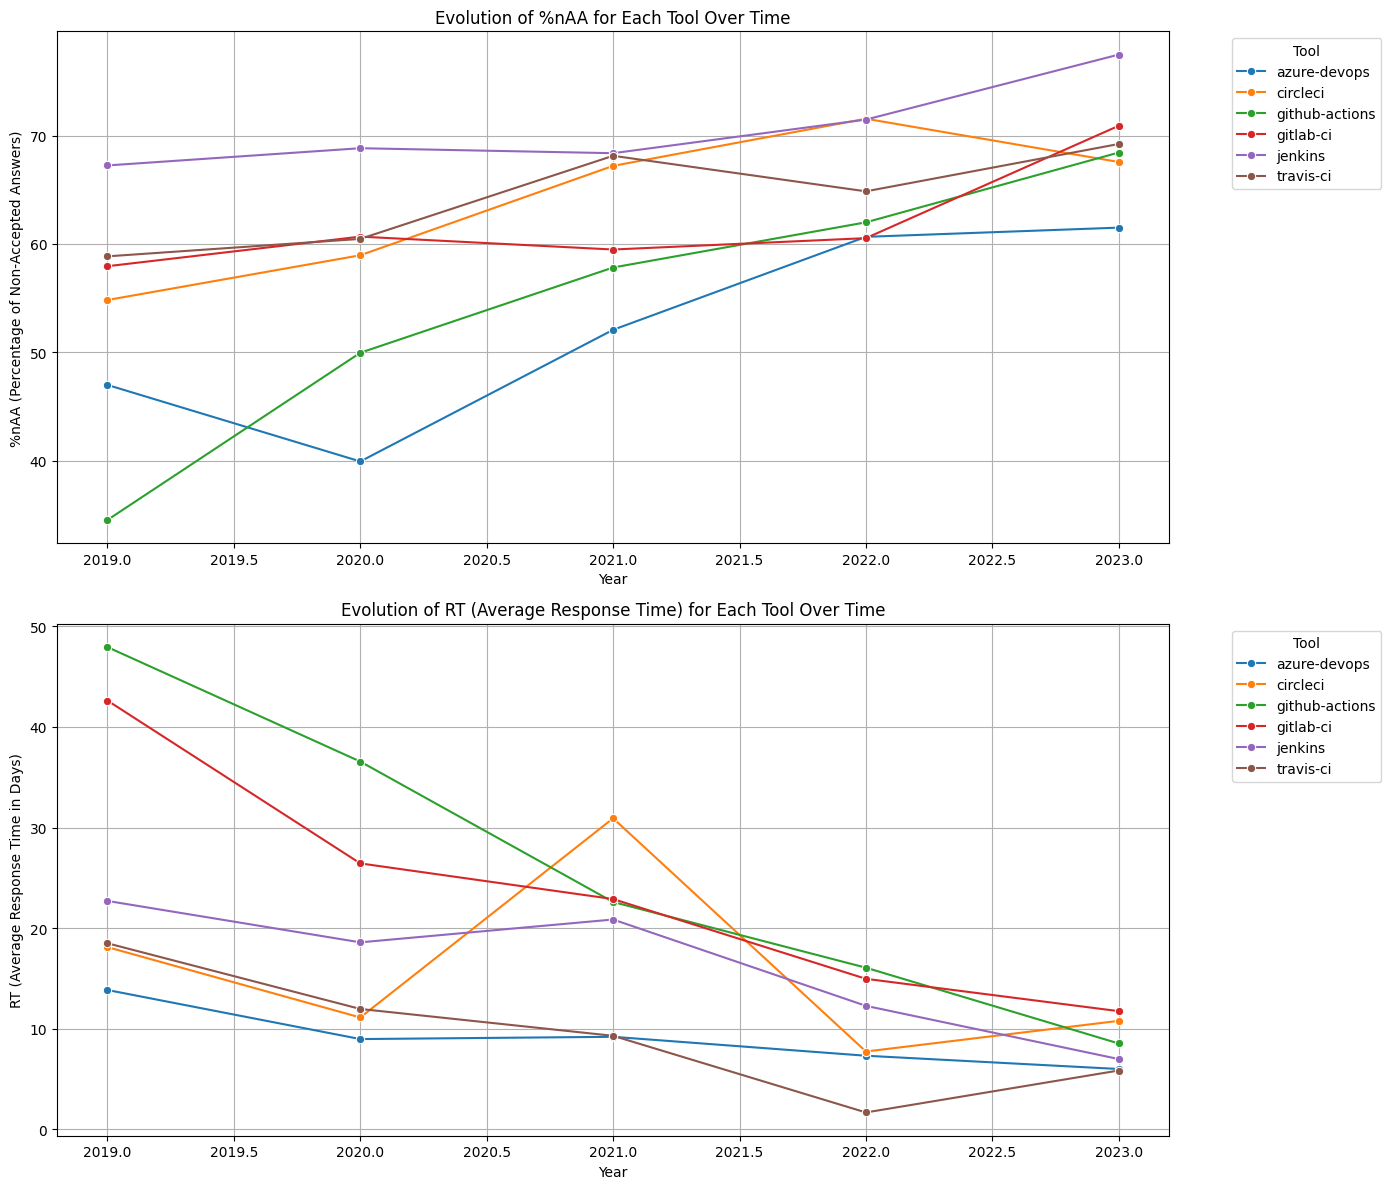

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set up the figure size
plt.figure(figsize=(14, 12))

# Plot 1: Evolution of %nAA for each tool over time
plt.subplot(2, 1, 1)
sns.lineplot(x='Year', y='%nAA', hue='Tool', data=filtered_df, marker='o')
plt.title('Evolution of %nAA for Each Tool Over Time')
plt.xlabel('Year')
plt.ylabel('%nAA (Percentage of Non-Accepted Answers)')
plt.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Plot 2: Evolution of RT for each tool over time
plt.subplot(2, 1, 2)
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', hue='Tool', data=filtered_df, marker='o')
plt.title('Evolution of RT (Average Response Time) for Each Tool Over Time')
plt.xlabel('Year')
plt.ylabel('RT (Average Response Time in Days)')
plt.legend(title='Tool', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Save the plot to a file named 'figs.png'
plt.savefig('figs/nAA_RT_vs_time_each_tool.png')

# Show the plots
plt.show()

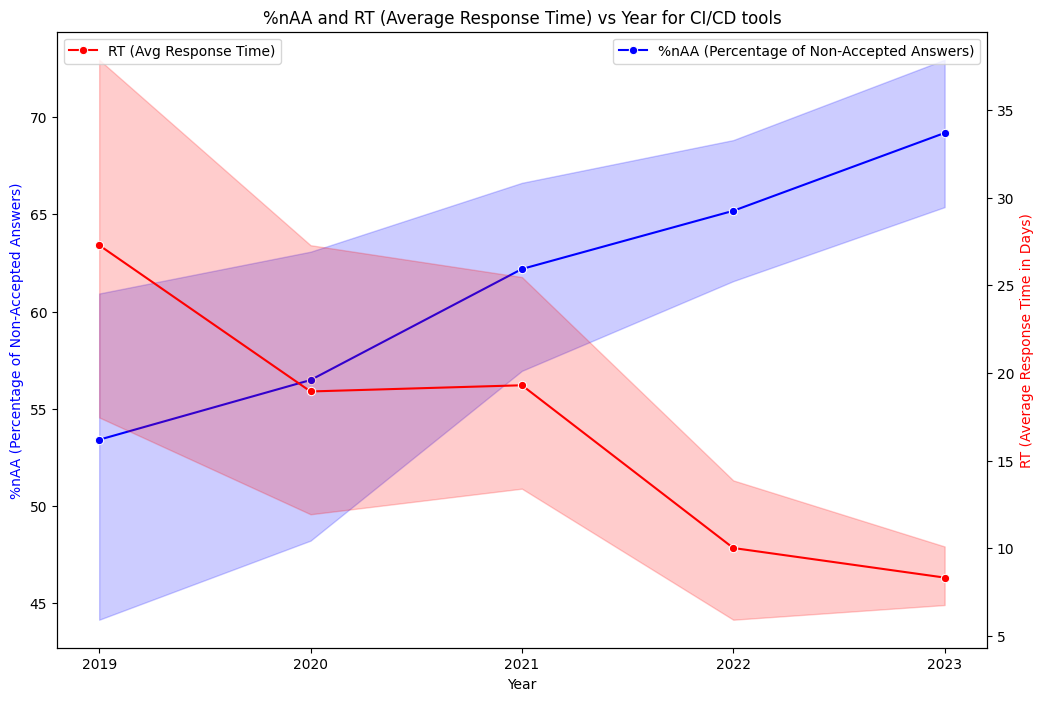

In [18]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for GitHub Actions
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting %nAA vs Year for GitHub Actions on the primary y-axis
sns.lineplot(x='Year', y='%nAA', data=filtered_df, marker='o', ax=ax1, label='%nAA (Percentage of Non-Accepted Answers)', color='b')

# Creating a second y-axis for RT
ax2 = ax1.twinx()

# Plotting RT vs Year on the second y-axis for GitHub Actions
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=filtered_df, marker='o', ax=ax2, label='RT (Avg Response Time)', color='r')

# Labels and title
plt.title('%nAA and RT (Average Response Time) vs Year for CI/CD tools')
ax1.set_xlabel('Year')
ax1.set_ylabel('%nAA (Percentage of Non-Accepted Answers)', color='b')
ax2.set_ylabel('RT (Average Response Time in Days)', color='r')

# Customizing the legends: Place the %nAA legend on the right and RT on the left
ax1.legend(loc='upper right')  # %nAA legend on the right
ax2.legend(loc='upper left')   # RT legend on the left

# Set x-ticks to display only specific years
ax1.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file named 'figs.png'
plt.savefig('figs/nAA_RT_vs_time.png')

# Show the plot
plt.show()

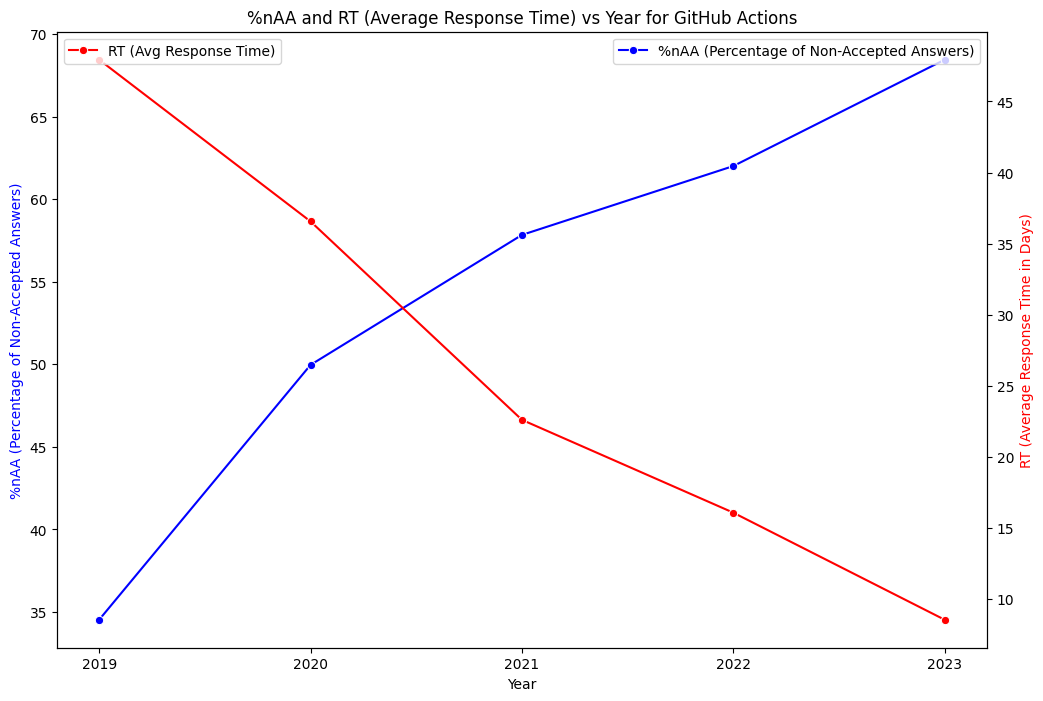

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter the data for GitHub Actions
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']

# Set the figure size
fig, ax1 = plt.subplots(figsize=(12, 8))

# Plotting %nAA vs Year for GitHub Actions on the primary y-axis
sns.lineplot(x='Year', y='%nAA', data=gha_df, marker='o', ax=ax1, label='%nAA (Percentage of Non-Accepted Answers)', color='b')

# Creating a second y-axis for RT
ax2 = ax1.twinx()

# Plotting RT vs Year on the second y-axis for GitHub Actions
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=gha_df, marker='o', ax=ax2, label='RT (Avg Response Time)', color='r')

# Labels and title
plt.title('%nAA and RT (Average Response Time) vs Year for GitHub Actions')
ax1.set_xlabel('Year')
ax1.set_ylabel('%nAA (Percentage of Non-Accepted Answers)', color='b')
ax2.set_ylabel('RT (Average Response Time in Days)', color='r')

# Customizing the legends: Place the %nAA legend on the right and RT on the left
ax1.legend(loc='upper right')  # %nAA legend on the right
ax2.legend(loc='upper left')   # RT legend on the left

# Set x-ticks to display only specific years
ax1.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file named 'figs.png'
plt.savefig('figs/nAA_RT_vs_time_gha.png')

# Show the plot
plt.show()

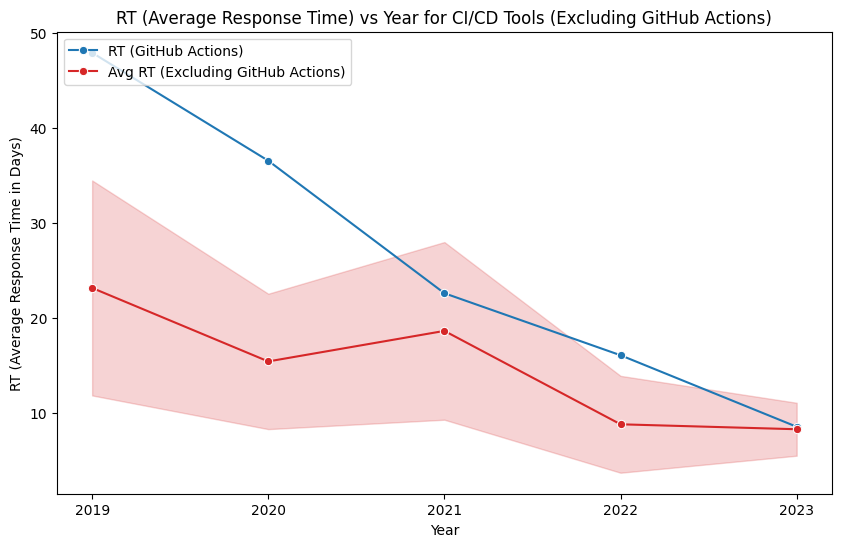

In [51]:
# Filter the data for GitHub Actions and other tools separately
gha_df = filtered_df[filtered_df['Tool'] == 'github-actions']
other_tools_df = filtered_df[filtered_df['Tool'] != 'github-actions']

# Calculate the average and standard deviation for RT for all tools except GitHub Actions
avg_other_tools = other_tools_df.groupby('Year').agg({
    'RT (Average Response Time in Days)': 'mean'
}).reset_index()

std_other_tools = other_tools_df.groupby('Year').agg({
    'RT (Average Response Time in Days)': 'std'
}).reset_index()

# Set the figure size
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting RT vs Year for other tools (average)
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=gha_df, marker='o', ax=ax, label='RT (GitHub Actions)', color='#1f77b4')
sns.lineplot(x='Year', y='RT (Average Response Time in Days)', data=avg_other_tools, marker='o', ax=ax, label='Avg RT (Excluding GitHub Actions)', color='#d62728')

# Adding shaded area for RT standard deviation
ax.fill_between(avg_other_tools['Year'], 
                 avg_other_tools['RT (Average Response Time in Days)'] - std_other_tools['RT (Average Response Time in Days)'], 
                 avg_other_tools['RT (Average Response Time in Days)'] + std_other_tools['RT (Average Response Time in Days)'], 
                 color='#d62728', alpha=0.2)

# Labels and title
plt.title('RT (Average Response Time) vs Year for CI/CD Tools (Excluding GitHub Actions)')
ax.set_xlabel('Year')
ax.set_ylabel('RT (Average Response Time in Days)')

# Customizing the legend
ax.legend(loc='upper left')  # RT legends

# Set x-ticks to display only specific years
ax.set_xticks([2019, 2020, 2021, 2022, 2023])

# Save the plot to a file
plt.savefig('figs/RT_vs_time_excluding_gha.png')

# Show the plot
plt.show()
